In [1]:
import numpy as np # linear algebra
from numpy import newaxis
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
print ('import completed')

Using TensorFlow backend.


import completed


In [2]:
# Enter in how much steps we will enroll the network.
# RNN/LSTM/GRU can be taught patterns over times series as big as the number of times you enrol them, and no bigger (fundamental limitation). 
# So by design these networks are deep/long to catch recurrent patterns.
Enrol_window = 100

print ('enrol window set to',Enrol_window )

enrol window set to 100


In [3]:
sc = MinMaxScaler(feature_range=(0,1))
def load_data(datasetname, column, seq_len, normalise_window):
    # A support function to help prepare datasets for an RNN/LSTM/GRU
    data = datasetname.loc[:,column]

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        #result = sc.fit_transform(result)
        result = normalise_windows(result)

    result = np.array(result)

    #Last 10% is used for validation test, first 90% for training
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    # A support function to normalize a dataset
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of <prediction_len> steps before shifting prediction run forward by <prediction_len> steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

def plot_results(predicted_data, true_data): 
    fig = plt.figure(facecolor='white') 
    ax = fig.add_subplot(111) 
    ax.plot(true_data, label='True Data') 
    plt.plot(predicted_data, label='Prediction') 
    plt.legend() 
    plt.show() 
    
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

print ('Support functions defined')


Support functions defined


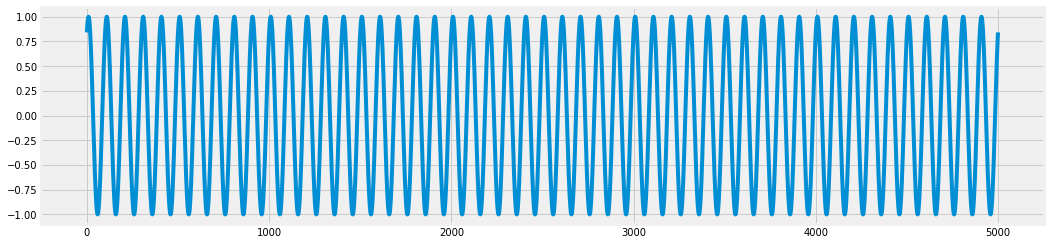

In [4]:
# Load the data
dataset = pd.read_csv('Sin Wave Data Generator.csv')
dataset["Wave"][:].plot(figsize=(16,4),legend=False)

In [5]:
# Prepare the dataset, note that all data foer the sinus wave is already normalized between 0 and 1
# A label is the thing we're predicting
# A feature is an input variable, in this case a stock price

feature_train, label_train, feature_test, label_test = load_data(dataset, 'Wave', Enrol_window, False)

print ('Datasets generated')

Datasets generated


In [6]:
# The LSTM model I would like to test
# Note: replace LSTM with GRU or RNN if you want to try those

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(feature_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "linear"))

model.compile(loss='mse', optimizer='adam')

print ('model compiled')

model compiled


In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_________________________________________________________________


In [11]:
#Train the model
model.fit(feature_train, label_train, batch_size=512, epochs=20, validation_data = (feature_test, label_test)) #epochs=10

Train on 4410 samples, validate on 490 samples
Epoch 1/20
4410/4410 [==============================] - 10s 2ms/step - loss: 0.0037 - val_loss: 2.2439e-04
Epoch 2/20
4410/4410 [==============================] - 10s 2ms/step - loss: 0.0035 - val_loss: 1.5436e-04
Epoch 3/20
4410/4410 [==============================] - 10s 2ms/step - loss: 0.0036 - val_loss: 1.2718e-04
Epoch 4/20
4410/4410 [==============================] - 10s 2ms/step - loss: 0.0033 - val_loss: 1.0682e-04
Epoch 5/20
4410/4410 [==============================] - 10s 2ms/step - loss: 0.0032 - val_loss: 8.2526e-05
Epoch 6/20
4410/4410 [==============================] - 10s 2ms/step - loss: 0.0032 - val_loss: 6.1979e-05
Epoch 7/20
4410/4410 [==============================] - 10s 2ms/step - loss: 0.0031 - val_loss: 1.0471e-04
Epoch 8/20
4410/4410 [==============================] - 10s 2ms/step - loss: 0.0031 - val_loss: 4.9413e-05
Epoch 9/20
4410/4410 [==============================] - 10s 2ms/step - loss: 0.0031 - val_loss: 8

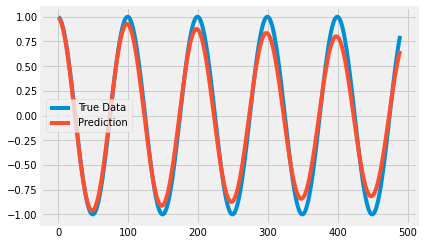

In [12]:
#Let's use the model and predict the wave
predictions= predict_sequence_full(model, feature_test, Enrol_window)
plot_results(predictions,label_test)

In [13]:
# Let's get the stock data
dataset = pd.read_csv('IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


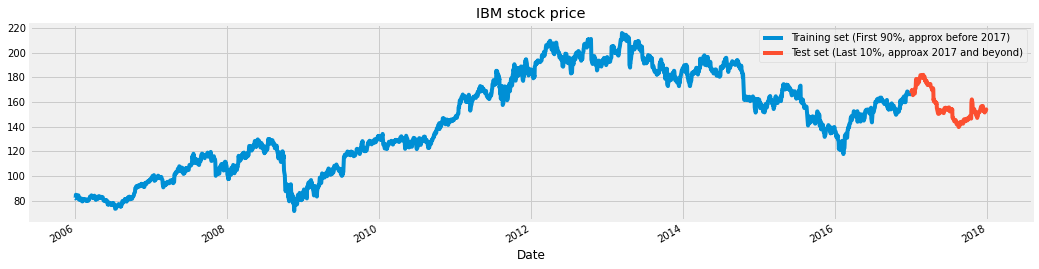

In [14]:
# Prepare the dataset, note that the stock price data will be normalized between 0 and 1
# A label is the thing we're predicting
# A feature is an input variable, in this case a stock price
# Selected 'Close' (stock pric at closing) attribute for prices. Let's see what it looks like

feature_train, label_train, feature_test, label_test = load_data(dataset, 'Close', Enrol_window, True)

dataset["Close"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["Close"]['2017':].plot(figsize=(16,4),legend=True) # 10% is used for thraining data which is approx 2017 data
plt.legend(['Training set (First 90%, approx before 2017)','Test set (Last 10%, approax 2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [15]:
# The same LSTM model I would like to test, lets see if the sinus prediction results can be matched
# Note: replace LSTM with GRU or RNN if you want to try those

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(feature_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "linear"))

model.compile(loss='mse', optimizer='adam')

print ('model compiled')

model compiled


In [16]:
#Train the model
model.fit(feature_train, label_train, batch_size=512, epochs=5, validation_data = (feature_test, label_test))

Train on 2627 samples, validate on 292 samples
Epoch 1/5
2627/2627 [==============================] - 6s 2ms/step - loss: 0.0069 - val_loss: 0.0015
Epoch 2/5
2627/2627 [==============================] - 6s 2ms/step - loss: 0.0021 - val_loss: 5.9618e-04
Epoch 3/5
2627/2627 [==============================] - 6s 2ms/step - loss: 0.0013 - val_loss: 8.9312e-04
Epoch 4/5
2627/2627 [==============================] - 6s 2ms/step - loss: 0.0010 - val_loss: 6.2308e-04
Epoch 5/5
2627/2627 [==============================] - 6s 2ms/step - loss: 0.0010 - val_loss: 4.5257e-04


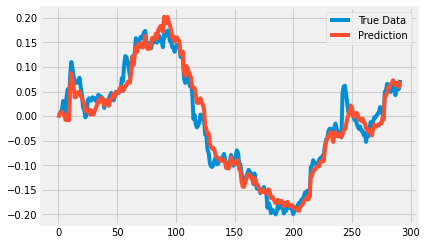

In [17]:
#Let's use the model and predict the stock
predicted_stock_price = model.predict(feature_test)
plot_results(predicted_stock_price,label_test)

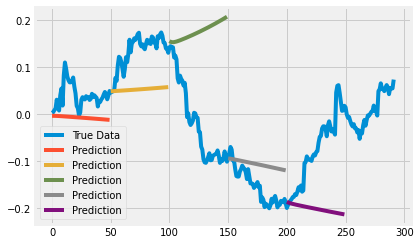

In [18]:
predictions = predict_sequences_multiple(model, feature_test, Enrol_window, 50)
plot_results_multiple(predictions, label_test, 50)  

In [0]:
pass